# PA KECERDASAN BUATAN
## Pendeteksi Keretakan pada Bangunan
## Kelompok 4
AZIIZAH OKI SHOFRINA (2109106004) <br>
ALIYA IRFANI         (2109106007) <br>
CHINTIA LIU WINTIN   (2109106008) <br>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Data Collecting

## A. Training Set

In [2]:
train_set = image_dataset_from_directory(
    "dataset/train",
    labels="inferred",
    label_mode="categorical",
    class_names=["Negative", "Positive"],
    image_size=(64, 64),
    shuffle=True,
    seed=1,
    subset="training",
    validation_split=0.1,
    batch_size=128
)

Found 36000 files belonging to 2 classes.
Using 32400 files for training.


## B. Validation Set

In [3]:
val_set = image_dataset_from_directory(
    "dataset/train",
    labels="inferred",
    label_mode="categorical",
    class_names=["Negative", "Positive"],
    image_size=(64, 64),
    shuffle=True,
    seed=1,
    subset="validation",
    validation_split=0.1,
    batch_size=128
)

Found 36000 files belonging to 2 classes.
Using 3600 files for validation.


## C. Testing Set

In [4]:
test_set = image_dataset_from_directory(
    "dataset/test",
    labels="inferred",
    label_mode="categorical",
    class_names=["Negative", "Positive"],
    image_size=(64, 64),
    shuffle=False,
    batch_size=128
)

Found 4000 files belonging to 2 classes.


### Kelas yang Digunakan

In [5]:
classes = train_set.class_names
classes

['Negative', 'Positive']

### Shape Gambar dan Label

In [6]:
for images, labels in train_set.take(1):
    print(images.shape)
    print(labels.shape)
    break

(128, 64, 64, 3)
(128, 2)


## Preview Gambar

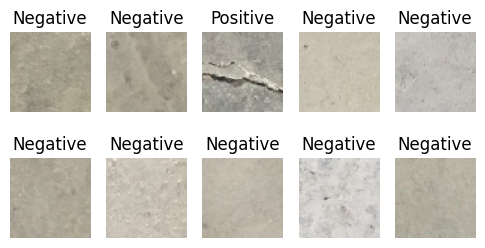

In [7]:
def preview_imgs(dataset):
    plt.figure(figsize=(6, 3))

    # ambil 1 batch
    for images, labels in dataset.take(1):
        
        # ambil 9 gambar
        for i in range(10):
            plt.subplot(2, 5, i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title("Negative" if labels[i].numpy()[0] == 1 else "Positive")
            plt.axis("off")
            
preview_imgs(train_set)

## Sample Gambar

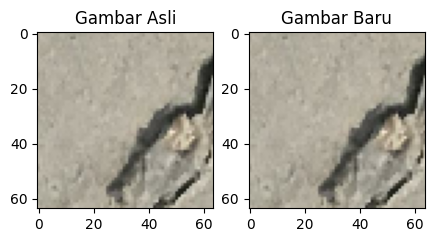

In [8]:
def sample_img(image1, image2):
    plt.figure(figsize=(5, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("Gambar Asli")
    plt.imshow(image1.numpy().astype("uint8"))
    
    plt.subplot(1, 2, 2)
    plt.title("Gambar Baru")
    plt.imshow(image2.numpy().astype("uint8"))

# ambil 1 contoh gambar
for images, labels in train_set.take(1):
    ori_img = images[0]

sample_img(ori_img, ori_img)

# 2. Data Preprocessing, Data Analisis, dan Visualisasi

## A. Brightness
Sesuaikan kecerahan gambar

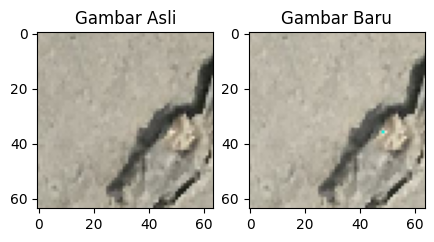

In [9]:
sample_img(ori_img, tf.image.random_brightness(ori_img, max_delta=10, seed=42))

#### Sesuaikan kecerahan dataset gambar

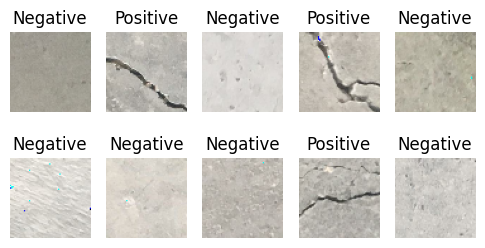

In [10]:
def brightness(x, y):
    image = tf.image.random_brightness(x, max_delta=10, seed=42)
    return image, y

b_train = train_set.map(brightness)
b_val = val_set.map(brightness)
b_test = test_set.map(brightness)

preview_imgs(b_train)

## B. Hue
Memberikan nuansa warna baru pada gambar

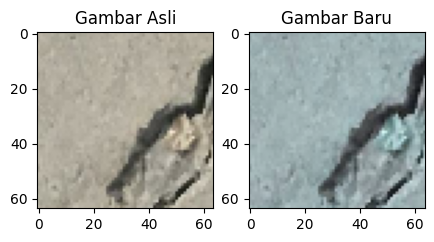

In [11]:
sample_img(ori_img, tf.image.random_hue(ori_img, max_delta=0.5, seed=42))

### Sesuaikan warna dataset gambar

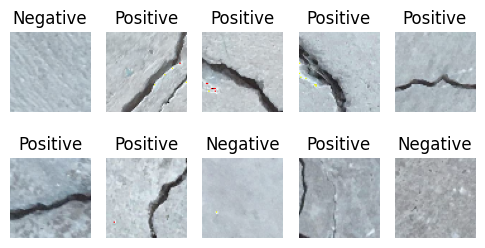

In [12]:
def hue(x, y):
    image = tf.image.random_hue(x, max_delta=0.5, seed=42)
    return image, y
    
hue_train = b_train.map(hue)
hue_val = b_val.map(hue)
hue_test = b_test.map(hue)

preview_imgs(hue_train)

## C. Saturation
Menyesuaikan insensitas warna. Semakin tinggi saturasi, semakin terang

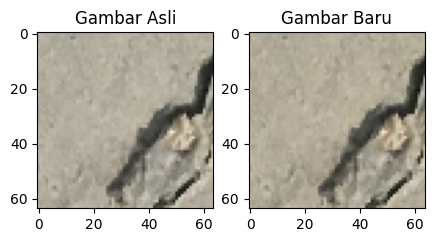

In [13]:
sample_img(ori_img, tf.image.random_saturation(ori_img, 0.5, 1.5, seed=42))

### Sesuaikan saturasi dataset gambar

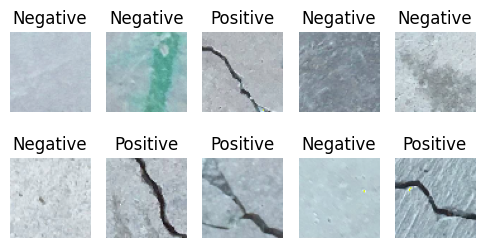

In [14]:
def saturate(x, y):
    image = tf.image.random_saturation(x, 0.5, 1.5, seed=42)
    return image, y
    
s_train = hue_train.map(saturate)
s_val = hue_val.map(saturate)
s_test = hue_test.map(saturate)

preview_imgs(s_train)

## D. Grayscale
Membuat gambar skala abu-abu

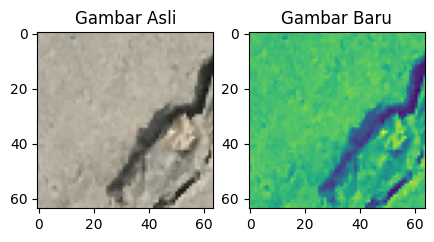

In [15]:
sample_img(ori_img, tf.image.rgb_to_grayscale(ori_img))

### Grayscaling dataset gambar

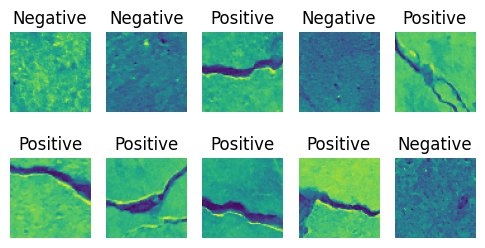

In [16]:
def grayscale(x, y):
    image = tf.image.rgb_to_grayscale(x)
    return image, y

g_train = train_set.map(grayscale)
g_val = val_set.map(grayscale)
g_test = test_set.map(grayscale)

preview_imgs(g_train)

### Shape Gambar Setelah Grayscaling

In [17]:
for image, label in g_train.take(1):
    print(image.numpy().shape)
    break

(128, 64, 64, 1)


## E. Contrast
Meningkatkan perbedaan antara bagian yang lebih cerah dan lebih gelap

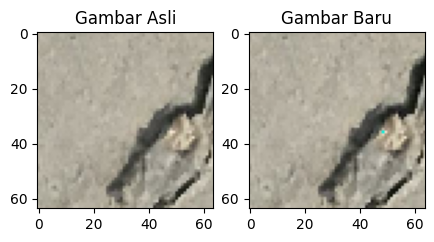

In [18]:
sample_img(ori_img, tf.image.random_contrast(ori_img, 1, 1.5, seed=42))

### Kontraskan dataset gambar RGB

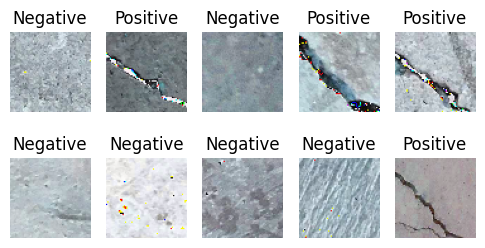

In [19]:
def contrast(x, y):
    image = tf.image.random_contrast(x, 1, 1.5, seed=42)
    return image, y

c_train_rgb = s_train.map(contrast)
c_val_rgb = s_val.map(contrast)
c_test_rgb = s_test.map(contrast)

preview_imgs(c_train_rgb)

### Kontraskan dataset gambar Grayscale

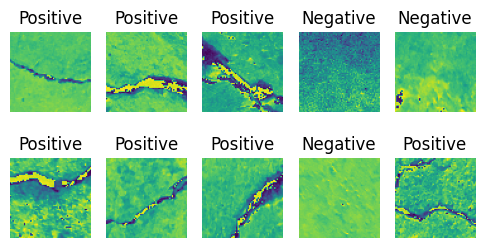

In [20]:
c_train_gray = g_train.map(contrast)
c_val_gray = g_val.map(contrast)
c_test_gray = g_test.map(contrast)

preview_imgs(c_train_gray)

## F. Standardisasi
Standardisasi gambar sehingga memiliki rata-rata 0 dan varians 1

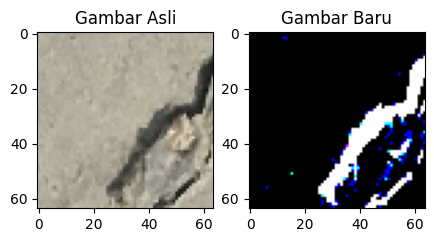

In [21]:
sample_img(ori_img, tf.image.per_image_standardization(ori_img))

### Standardisasi dataset gambar RGB

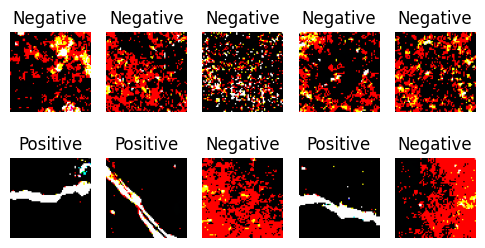

In [22]:
def standardization(x, y):
    image = tf.image.per_image_standardization(x)
    return image, y

std_train_rgb = c_train_rgb.map(standardization)
std_val_rgb = c_val_rgb.map(standardization)
std_test_rgb = c_test_rgb.map(standardization)

preview_imgs(std_train_rgb)

### Standardisasi dataset gambar Grayscale

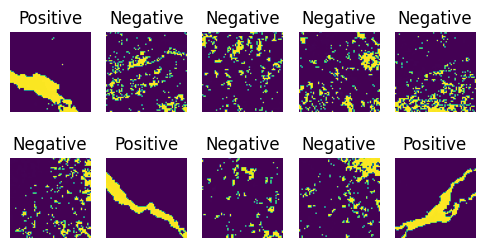

In [23]:
std_train_gray = c_train_gray.map(standardization)
std_val_gray = c_val_gray.map(standardization)
std_test_gray = c_test_gray.map(standardization)

preview_imgs(std_train_gray)

# 3. Data Modelling dan Evaluasi

## A. Model RGB

In [24]:
model_rgb = Sequential([
    Input((64, 64, 3)),
    
    Conv2D(16, (3, 3), activation="relu"),
    MaxPooling2D(),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D(),
    
    Flatten(),
    Dense(2, activation="sigmoid")
])

model_rgb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 2)                 1

In [25]:
model_rgb.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

### Model RGB - Fitting Model

In [26]:
history_rgb = model_rgb.fit(
    c_train_rgb,
    validation_data=c_val_rgb,
    epochs=10,
    verbose=1
)

Epoch 1/10
254/254 [==============================] - 96s 369ms/step - loss: 1.6081 - accuracy: 0.9447 - val_loss: 0.0823 - val_accuracy: 0.9814
Epoch 2/10
254/254 [==============================] - 86s 336ms/step - loss: 0.0709 - accuracy: 0.9846 - val_loss: 0.0768 - val_accuracy: 0.9844
Epoch 3/10
254/254 [==============================] - 83s 323ms/step - loss: 0.0449 - accuracy: 0.9891 - val_loss: 0.0547 - val_accuracy: 0.9872
Epoch 4/10
254/254 [==============================] - 86s 335ms/step - loss: 0.0375 - accuracy: 0.9902 - val_loss: 0.0402 - val_accuracy: 0.9897
Epoch 5/10
254/254 [==============================] - 86s 335ms/step - loss: 0.0259 - accuracy: 0.9926 - val_loss: 0.0425 - val_accuracy: 0.9908
Epoch 6/10
254/254 [==============================] - 89s 349ms/step - loss: 0.0205 - accuracy: 0.9944 - val_loss: 0.0263 - val_accuracy: 0.9925
Epoch 7/10
254/254 [==============================] - 81s 316ms/step - loss: 0.0174 - accuracy: 0.9950 - val_loss: 0.0365 - val_ac

### Model RGB - Visualisasi Training Validation

In [27]:
def visualisasi_plot(model):
    epoch = [i+1 for i in range(10)]

    sns.set_theme()

    plt.figure(figsize=(14, 7))
    plt.suptitle("Train vs Validation")

    # grafik akurasi
    plt.subplot(1, 2, 1)
    plt.title("Akurasi")
    sns.lineplot(
        x=epoch,
        y=model.history["accuracy"],
        label="Training"
    )
    sns.lineplot(
        x=epoch,
        y=model.history["val_accuracy"],
        label="Validation"
    )
    plt.xticks(epoch)
    plt.xlabel("Epoch")
    plt.ylabel("Akurasi(%)")

    # grafik loss
    plt.subplot(1, 2, 2)
    plt.title("Loss")
    sns.lineplot(
        x=epoch,
        y=model.history["loss"],
        label="Training"
    )
    sns.lineplot(
        x=epoch,
        y=model.history["val_loss"],
        label="Validation"
    )
    plt.xticks(epoch)
    plt.xlabel("Epoch")
    plt.ylabel("Loss(%)")

    plt.show()

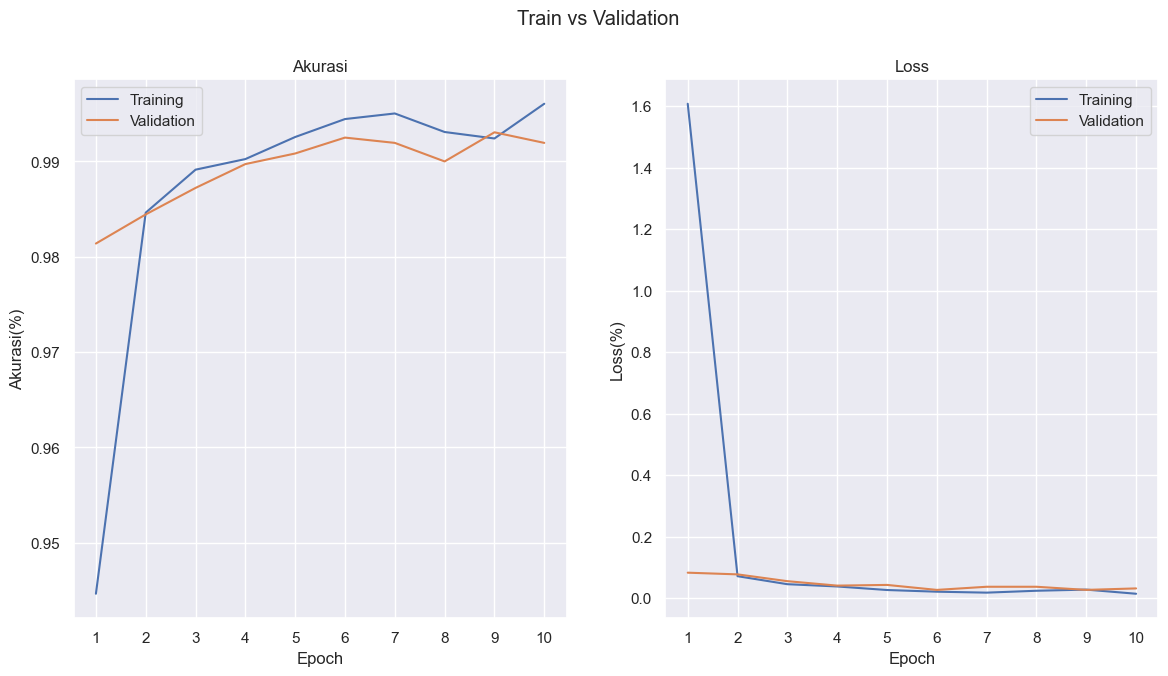

In [28]:
visualisasi_plot(history_rgb)

### Model RGB - Evaluasi Testing

In [29]:
def evaluate_model(model, test_set, hasil_prediksi):
    score = model.evaluate(test_set, verbose=1)
    
    print(
        f"Test Loss     : {score[0]}\
        \nTest Accuracy : {score[1]*100}%"
    )
    
    labels = [label[1] for image, label in test_set.unbatch()]
    labels_pred = [label[1] for label in hasil_prediksi]
    
    plt.figure(figsize=(7, 7))
    cm = confusion_matrix(labels, labels_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Negative", "Positive"]
    )
    disp.plot(cmap=plt.cm.Blues)
    plt.grid(False)
    
    plt.show()

In [30]:
prediksi_rgb = [[1, 0] if label[0] > label[1] else [0, 1] for label in model_rgb.predict(c_test_rgb)]

32/32 [==============================] - 19s 583ms/step


32/32 [==============================] - 5s 152ms/step - loss: 0.0202 - accuracy: 0.9937
Test Loss     : 0.020205844193696976        
Test Accuracy : 99.37499761581421%


<Figure size 700x700 with 0 Axes>

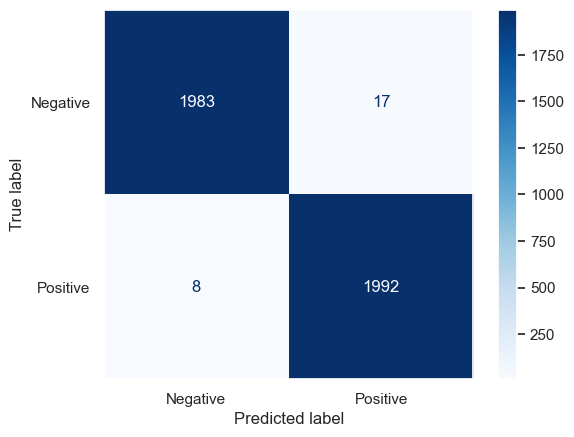

In [31]:
evaluate_model(model_rgb, c_test_rgb, prediksi_rgb)

### Model RGB - Prediksi Test Set

In [32]:
def show_prediction(test_set, hasil_prediksi):

    images = []
    labels = []
    labels_pred = []

    i = 0
    # simpan ke list
    for image, label in test_set.unbatch():
        images.append(image.numpy().astype("uint8"))
        labels.append("Negative" if label[0] == 1 else "Positive")
        labels_pred.append("Negative" if hasil_prediksi[i][0] == 1 else "Positive")
        i += 1

    plt.figure(figsize=(12, 4))

    # tampilkan 14 gambar prediksi
    for i in range(14):
        plt.subplot(2, 7, i+1)

        # ambil gambar acak
        index = randint(0, len(images))
        plt.imshow(images[index])

        # label prediksi
        color = "green" if labels_pred[index] == labels[index] else "red"
        plt.title(f"{labels_pred[index]}", color=color)

        plt.axis("off")


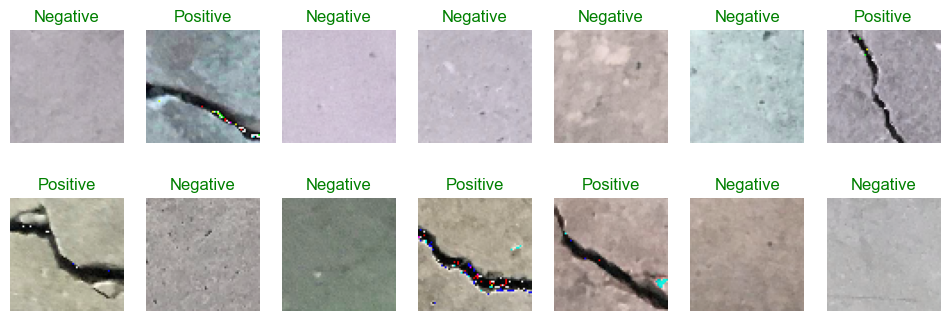

In [33]:
show_prediction(c_test_rgb, prediksi_rgb)

### Model RGB - Kesalahan Prediksi Test Set

In [34]:
def show_mistakes(test_set, hasil_prediksi):
    images = []
    labels = []
    labels_pred = []
    i=0
    
    for image, label in test_set.unbatch():

        # simpan hasil yang salah
        if (label[0] != hasil_prediksi[i][0]):
            images.append(image.numpy().astype("uint8"))
            labels.append("Negative" if label[0] == 1 else "Positive")
            labels_pred.append("Negative" if hasil_prediksi[i][0] == 1 else "Positive")
        i+=1

    # tampilkan prediksi yang salah
    plt.figure(figsize=(12, 12))
    i=0
    for i in range(len(images)):
        plt.subplot(7, 7, i+1)
        plt.imshow(images[i])
        plt.title(labels_pred[i], color="red")
        plt.axis("off")
        
    plt.show()

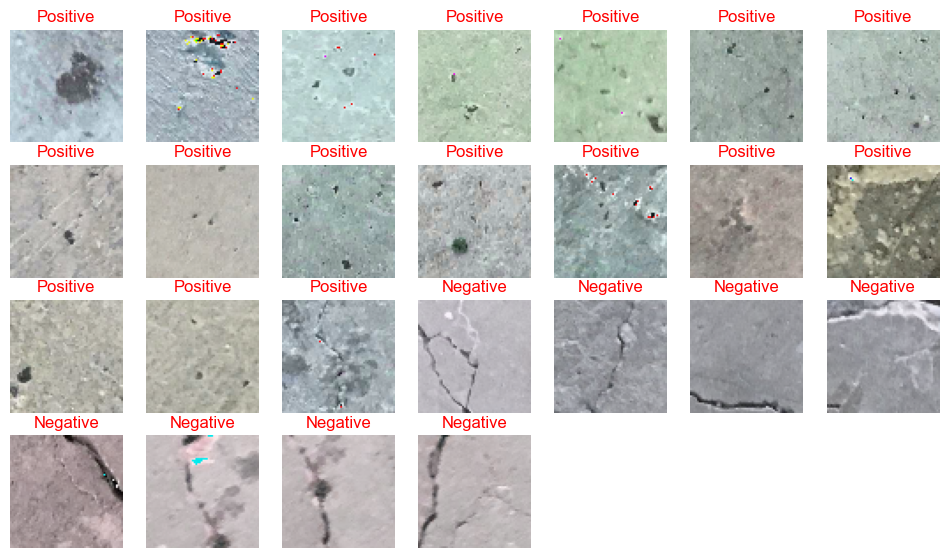

In [35]:
show_mistakes(c_test_rgb, prediksi_rgb)

## B. Model RGB Standardisasi

In [36]:
model_rgb_std = Sequential([
    Input((64, 64, 3)),
    
    Conv2D(16, (3, 3), activation="relu"),
    MaxPooling2D(),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D(),
    
    Flatten(),
    Dense(2, activation="sigmoid")
])

model_rgb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 2)                 1

In [37]:
model_rgb_std.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

### Model RGB Standardisasi - Fitting Model

In [38]:
history_rgb_std = model_rgb_std.fit(
    std_train_rgb,
    validation_data=std_val_rgb,
    epochs=10,
    verbose=1
)

Epoch 1/10
254/254 [==============================] - 88s 340ms/step - loss: 0.1311 - accuracy: 0.9451 - val_loss: 0.0528 - val_accuracy: 0.9828
Epoch 2/10
254/254 [==============================] - 76s 296ms/step - loss: 0.0382 - accuracy: 0.9873 - val_loss: 0.0307 - val_accuracy: 0.9900
Epoch 3/10
254/254 [==============================] - 88s 344ms/step - loss: 0.0264 - accuracy: 0.9910 - val_loss: 0.0707 - val_accuracy: 0.9744
Epoch 4/10
254/254 [==============================] - 88s 342ms/step - loss: 0.0228 - accuracy: 0.9927 - val_loss: 0.0176 - val_accuracy: 0.9922
Epoch 5/10
254/254 [==============================] - 88s 345ms/step - loss: 0.0144 - accuracy: 0.9955 - val_loss: 0.0164 - val_accuracy: 0.9942
Epoch 6/10
254/254 [==============================] - 91s 357ms/step - loss: 0.0137 - accuracy: 0.9955 - val_loss: 0.0152 - val_accuracy: 0.9942
Epoch 7/10
254/254 [==============================] - 86s 336ms/step - loss: 0.0087 - accuracy: 0.9974 - val_loss: 0.0151 - val_ac

### Model RGB Standardisasi - Visualisasi Training Validation

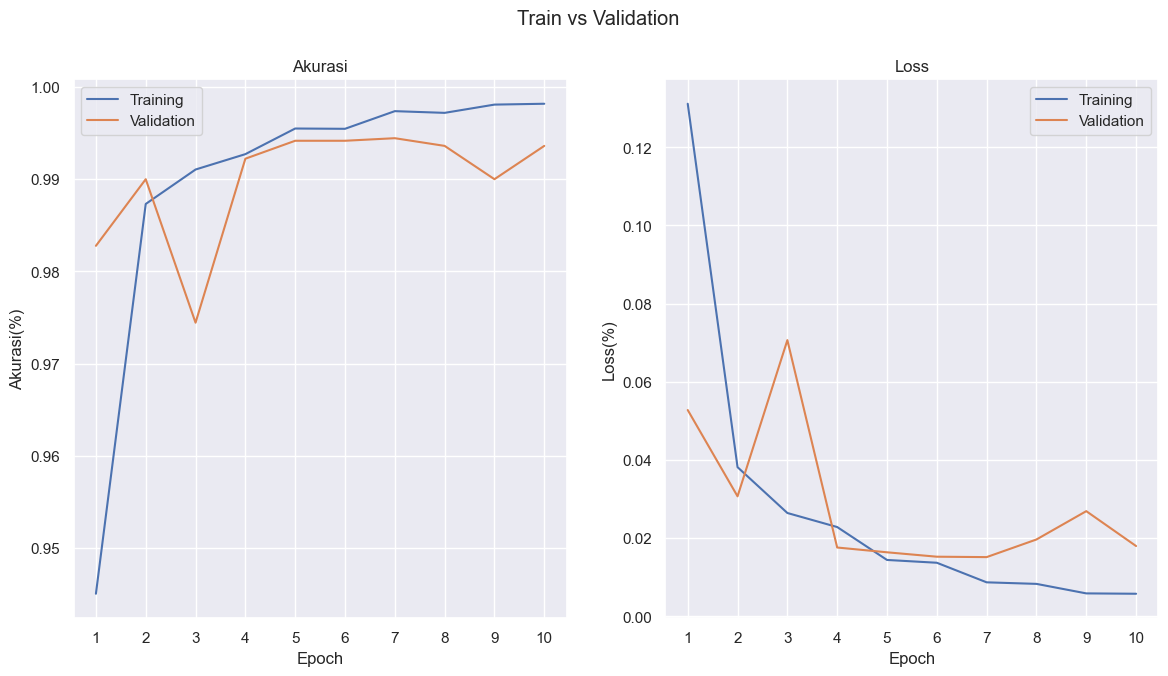

In [39]:
visualisasi_plot(history_rgb_std)

### Model RGB Standardisasi - Evaluasi Testing

In [40]:
prediksi_rgb_std = (model_rgb_std.predict(std_test_rgb).squeeze() >= 0.5).astype(int)

32/32 [==============================] - 5s 129ms/step


32/32 [==============================] - 5s 139ms/step - loss: 0.0266 - accuracy: 0.9927
Test Loss     : 0.02655601315200329        
Test Accuracy : 99.27499890327454%


<Figure size 700x700 with 0 Axes>

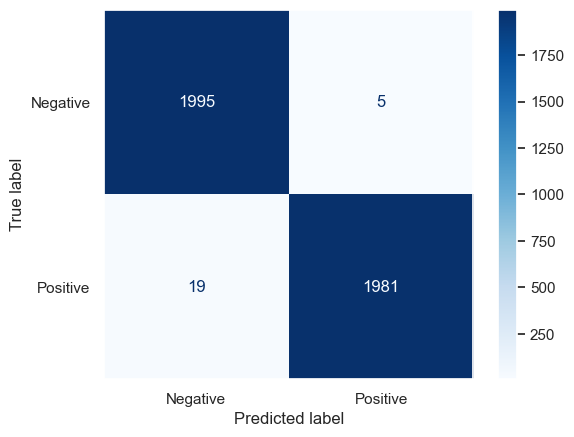

In [41]:
evaluate_model(model_rgb_std, std_test_rgb, prediksi_rgb_std)

### Model RGB Standardisasi - Prediksi Test Set

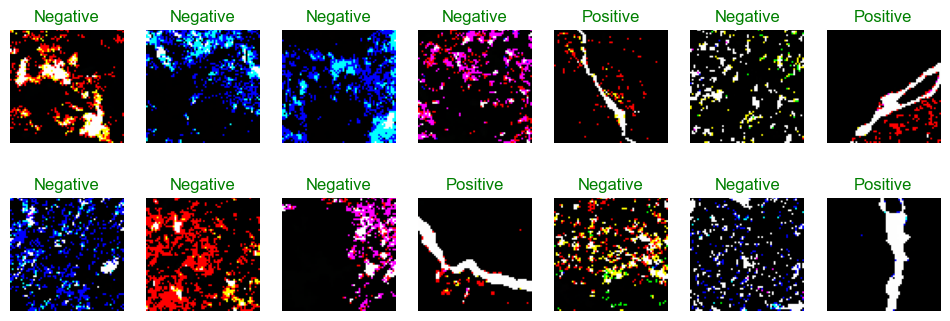

In [42]:
show_prediction(std_test_rgb, prediksi_rgb_std)

### Model RGB Standardisasi - Kesalahan Prediksi Test Set

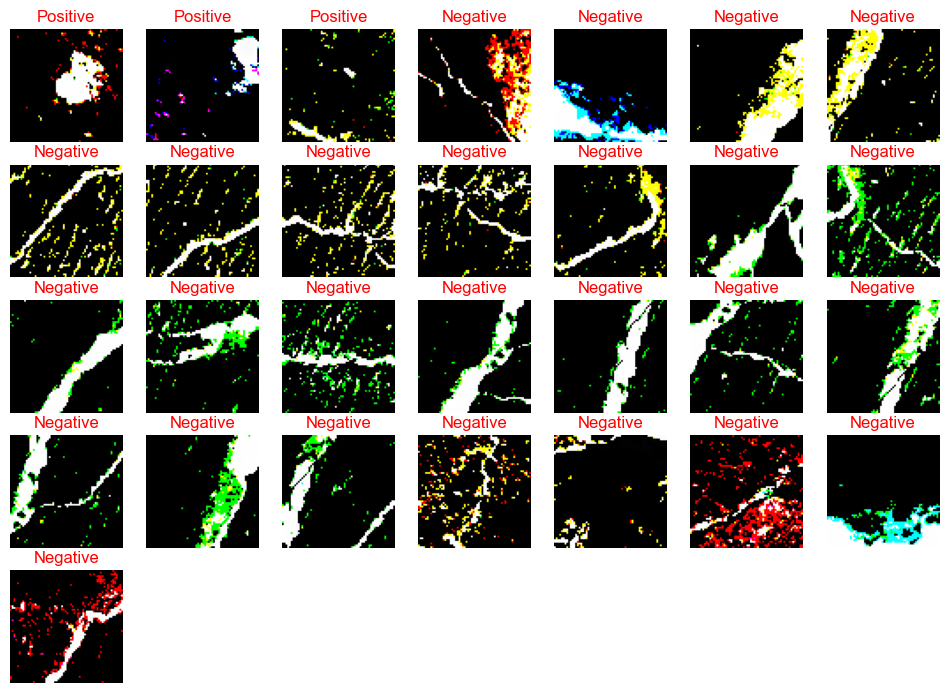

In [43]:
show_mistakes(std_test_rgb, prediksi_rgb_std)

## C. Model Grayscale

In [44]:
model_gray = Sequential([
    Input((64, 64, 1)),

    Conv2D(16, (3, 3), activation="relu"),
    MaxPooling2D(),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D(),

    Flatten(),
    Dense(2, activation="sigmoid")
])

model_gray.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 16)        160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 6272)              0         
                                                                 
 dense_2 (Dense)             (None, 2)                

In [45]:
model_gray.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

### Model Grayscale - Fitting Model

In [46]:
history_gray = model_gray.fit(
    c_train_gray,
    validation_data=c_val_gray,
    epochs=10,
    verbose=1
)

Epoch 1/10
254/254 [==============================] - 71s 273ms/step - loss: 1.5205 - accuracy: 0.9464 - val_loss: 0.0533 - val_accuracy: 0.9842
Epoch 2/10
254/254 [==============================] - 77s 302ms/step - loss: 0.0634 - accuracy: 0.9813 - val_loss: 0.0662 - val_accuracy: 0.9825
Epoch 3/10
254/254 [==============================] - 82s 319ms/step - loss: 0.0615 - accuracy: 0.9821 - val_loss: 0.0459 - val_accuracy: 0.9858
Epoch 4/10
254/254 [==============================] - 84s 329ms/step - loss: 0.0495 - accuracy: 0.9857 - val_loss: 0.0521 - val_accuracy: 0.9847
Epoch 5/10
254/254 [==============================] - 86s 334ms/step - loss: 0.0488 - accuracy: 0.9857 - val_loss: 0.0506 - val_accuracy: 0.9853
Epoch 6/10
254/254 [==============================] - 79s 307ms/step - loss: 0.0366 - accuracy: 0.9891 - val_loss: 0.0529 - val_accuracy: 0.9889
Epoch 7/10
254/254 [==============================] - 79s 308ms/step - loss: 0.0328 - accuracy: 0.9903 - val_loss: 0.0401 - val_ac

### Model Grayscale - Visualisasi Training Validation

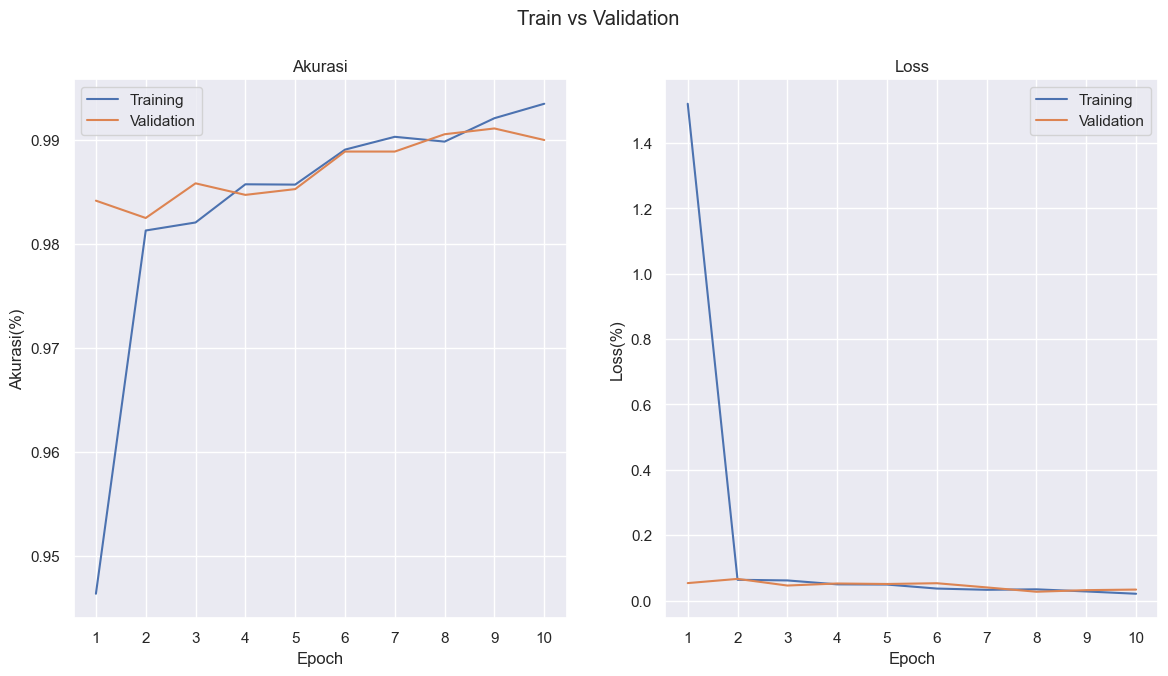

In [47]:
visualisasi_plot(history_gray)

### Model Grayscale - Evaluasi Testing

32/32 [==============================] - 5s 145ms/step - loss: 0.0219 - accuracy: 0.9952
Test Loss     : 0.02187236398458481        
Test Accuracy : 99.52499866485596%


<Figure size 700x700 with 0 Axes>

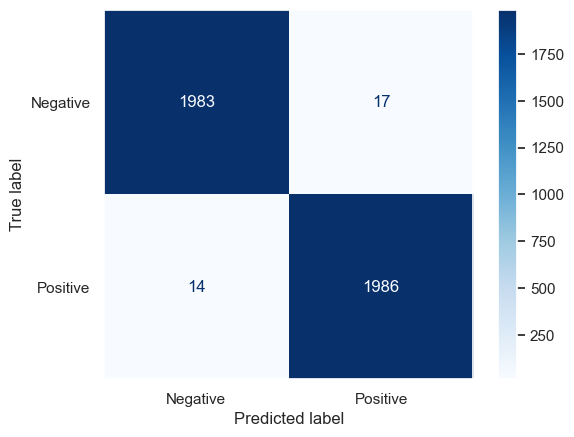

In [48]:
prediksi_gray = (model_gray.predict(c_test_gray).squeeze() >= 0.5).astype(int)

evaluate_model(model_gray, c_test_gray, prediksi_gray)

### Model Grayscale - Prediksi Test Set

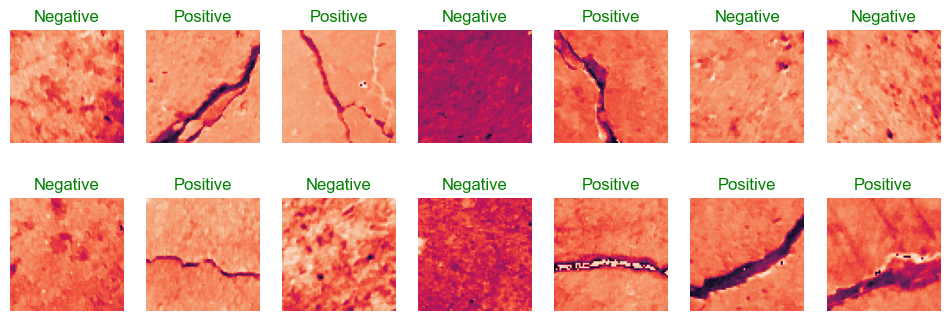

In [49]:
show_prediction(c_test_gray, prediksi_gray)

### Model Grayscale - Kesalahan Prediksi Test Set

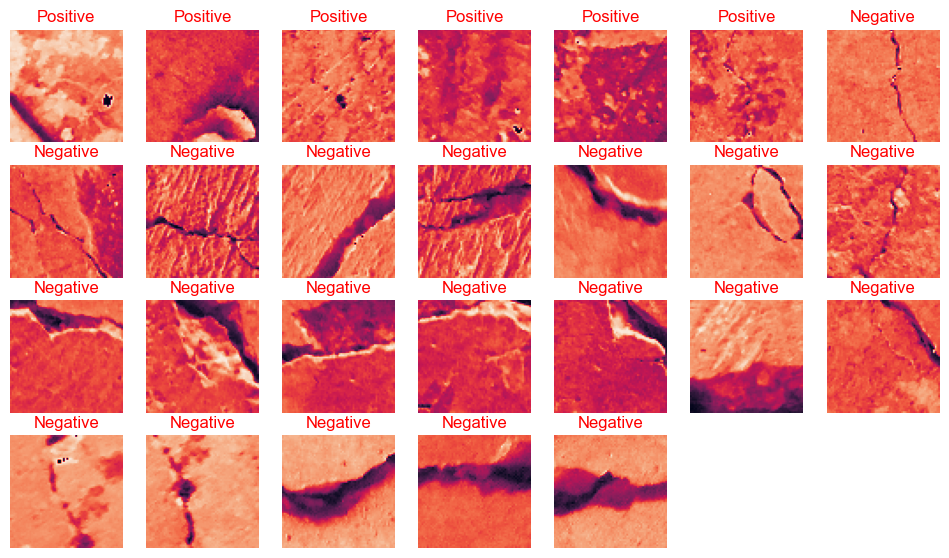

In [50]:
show_mistakes(c_test_gray, prediksi_gray)

## D. Model Grayscale Standardisasi

In [51]:
model_gray_std = Sequential([
    Input((64, 64, 1)),

    Conv2D(16, (3, 3), activation="relu"),
    MaxPooling2D(),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D(),

    Flatten(),
    Dense(2, activation="sigmoid")
])

model_gray.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 16)        160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 6272)              0         
                                                                 
 dense_2 (Dense)             (None, 2)                

In [52]:
model_gray_std.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

### Model Grayscale Standardisasi - Fitting Model

In [53]:
history_gray_std = model_gray_std.fit(
    std_train_gray,
    validation_data = std_val_gray,
    epochs=10,
    verbose=1
)

Epoch 1/10
254/254 [==============================] - 93s 364ms/step - loss: 0.1245 - accuracy: 0.9527 - val_loss: 0.0488 - val_accuracy: 0.9822
Epoch 2/10
254/254 [==============================] - 86s 335ms/step - loss: 0.0478 - accuracy: 0.9848 - val_loss: 0.0415 - val_accuracy: 0.9842
Epoch 3/10
254/254 [==============================] - 90s 353ms/step - loss: 0.0343 - accuracy: 0.9886 - val_loss: 0.0329 - val_accuracy: 0.9883
Epoch 4/10
254/254 [==============================] - 84s 328ms/step - loss: 0.0255 - accuracy: 0.9916 - val_loss: 0.0219 - val_accuracy: 0.9919
Epoch 5/10
254/254 [==============================] - 92s 359ms/step - loss: 0.0185 - accuracy: 0.9943 - val_loss: 0.0203 - val_accuracy: 0.9922
Epoch 6/10
254/254 [==============================] - 97s 375ms/step - loss: 0.0145 - accuracy: 0.9960 - val_loss: 0.0210 - val_accuracy: 0.9931
Epoch 7/10
254/254 [==============================] - 81s 317ms/step - loss: 0.0128 - accuracy: 0.9957 - val_loss: 0.0381 - val_ac

### Model Grayscale Standardisasi - Visualisasi Training Validation

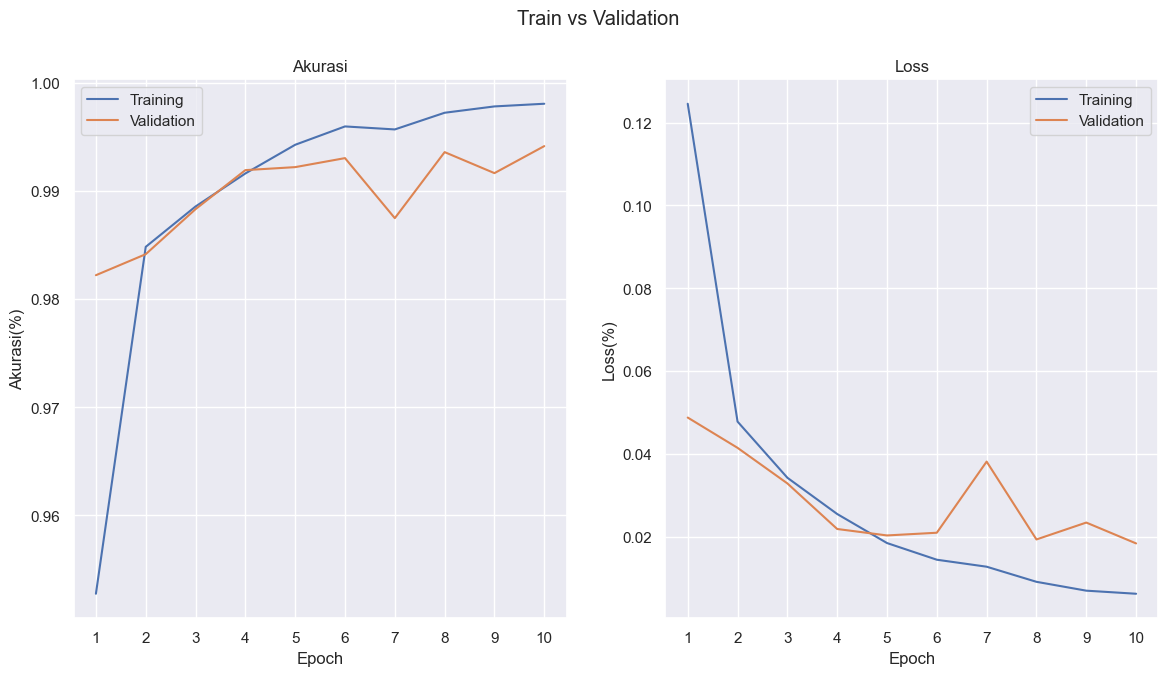

In [54]:
visualisasi_plot(history_gray_std)

### Model Grayscale Standardisasi - Evaluasi Testing

In [56]:
prediksi_gray_std = (model_gray_std.predict(std_test_gray).squeeze() >= 0.5).astype(int)

32/32 [==============================] - 4s 109ms/step


32/32 [==============================] - 5s 139ms/step - loss: 0.0291 - accuracy: 0.9915
Test Loss     : 0.02911725454032421        
Test Accuracy : 99.15000200271606%


<Figure size 700x700 with 0 Axes>

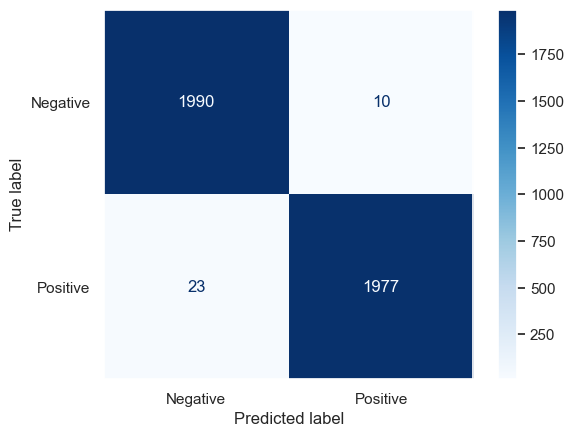

In [57]:
evaluate_model(model_gray_std, std_test_gray, prediksi_gray_std)

### Model Grayscale Standardisasi - Prediksi Test Set

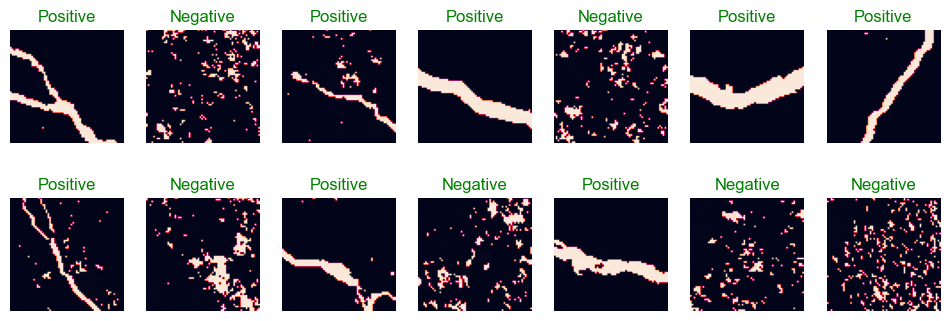

In [58]:
show_prediction(std_test_gray, prediksi_gray_std)

### Model Grayscale Standardisasi - Kesalahan Prediksi Test Set

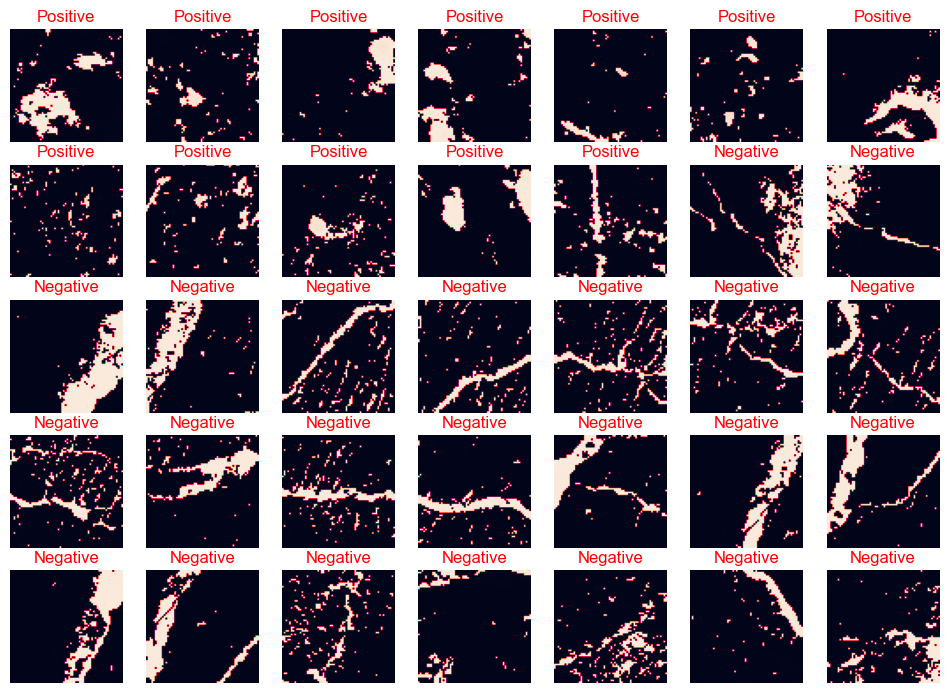

In [59]:
show_mistakes(std_test_gray, prediksi_gray_std)